# Network Diffusion Library

Network Diffusion Library (`NDlib`) to prosta biblioteka umożliwiająca implementację dyskretnych i ciągłych modeli rozprzestrzeniania się w sieciach społecznościowych. Jest ściśle zintegrowana z bibliotekami `networkx` oraz `igraph`. Poniższy tutorial przedstawi kilka prostych przykładów zamodelowania zjawisk wiralnych w sieciach.

## Prosty model SIR

W poniższym modelu zakładamy, że wierzchołki mogą znajdować się w jednym z trzech stanów:

- `S`: susceptible
- `I`: infected
- `R`: recovered

Przebieg epidemii prześledzimy na przykładzie sieci losowej wygenerowanej z modelu Erdosa-Renyiego.

In [2]:
import networkx as nx
import ndlib.models.epidemics as ep

g = nx.erdos_renyi_graph(1000, 0.1)
model = ep.SIRModel(g)

Pierwszym krokiem jest zdefiniowanie parametrów modelu

In [3]:
import ndlib.models.ModelConfig as mc

config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)

model.set_initial_status(config)

Kolejnym krokiem jest wykonanie kroku symulacji, w którym nastąpi przejście między poszczególnymi kategoriami. Pojedynczą iterację można zrealizować przez `model.iteration()`, my jednak od razu wykonamy $n$ iteracji.

In [3]:
iterations = model.iteration_bunch(5)
trends = model.build_trends(iterations)

trends

[{'trends': {'node_count': {0: [950, 944, 936, 931, 925],
    1: [50, 55, 61, 66, 72],
    2: [0, 1, 3, 3, 3]},
   'status_delta': {0: [0, -6, -8, -5, -6],
    1: [0, 5, 6, 5, 6],
    2: [0, 1, 2, 0, 0]}}}]

In [4]:
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

W efekcie uzyskujemy obiekt zawierający informację o przejściach pomiędzy stanami w poszczególnych krokach symulacji.

Ostatnim krokiem prostego eksperymentu jest wizualizacja przebiegu symulacji. Pierwszy wykres pokazuje zmianę w liczbie wierzchołków zainfekowanych, podatnych na infekcję oraz wyleczonych.

In [5]:
%matplotlib inline

import bokeh
from bokeh.io import show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend

viz = DiffusionTrend(model, trends)
p = viz.plot(width=600, height=600)
show(p)

Opening in existing browser session.


Jeśli lokalnie nie ma zainstalowanej biblioteki `bokeh` to `ndlib` może też wykorzystać `matplotlib` do wizualizacji.

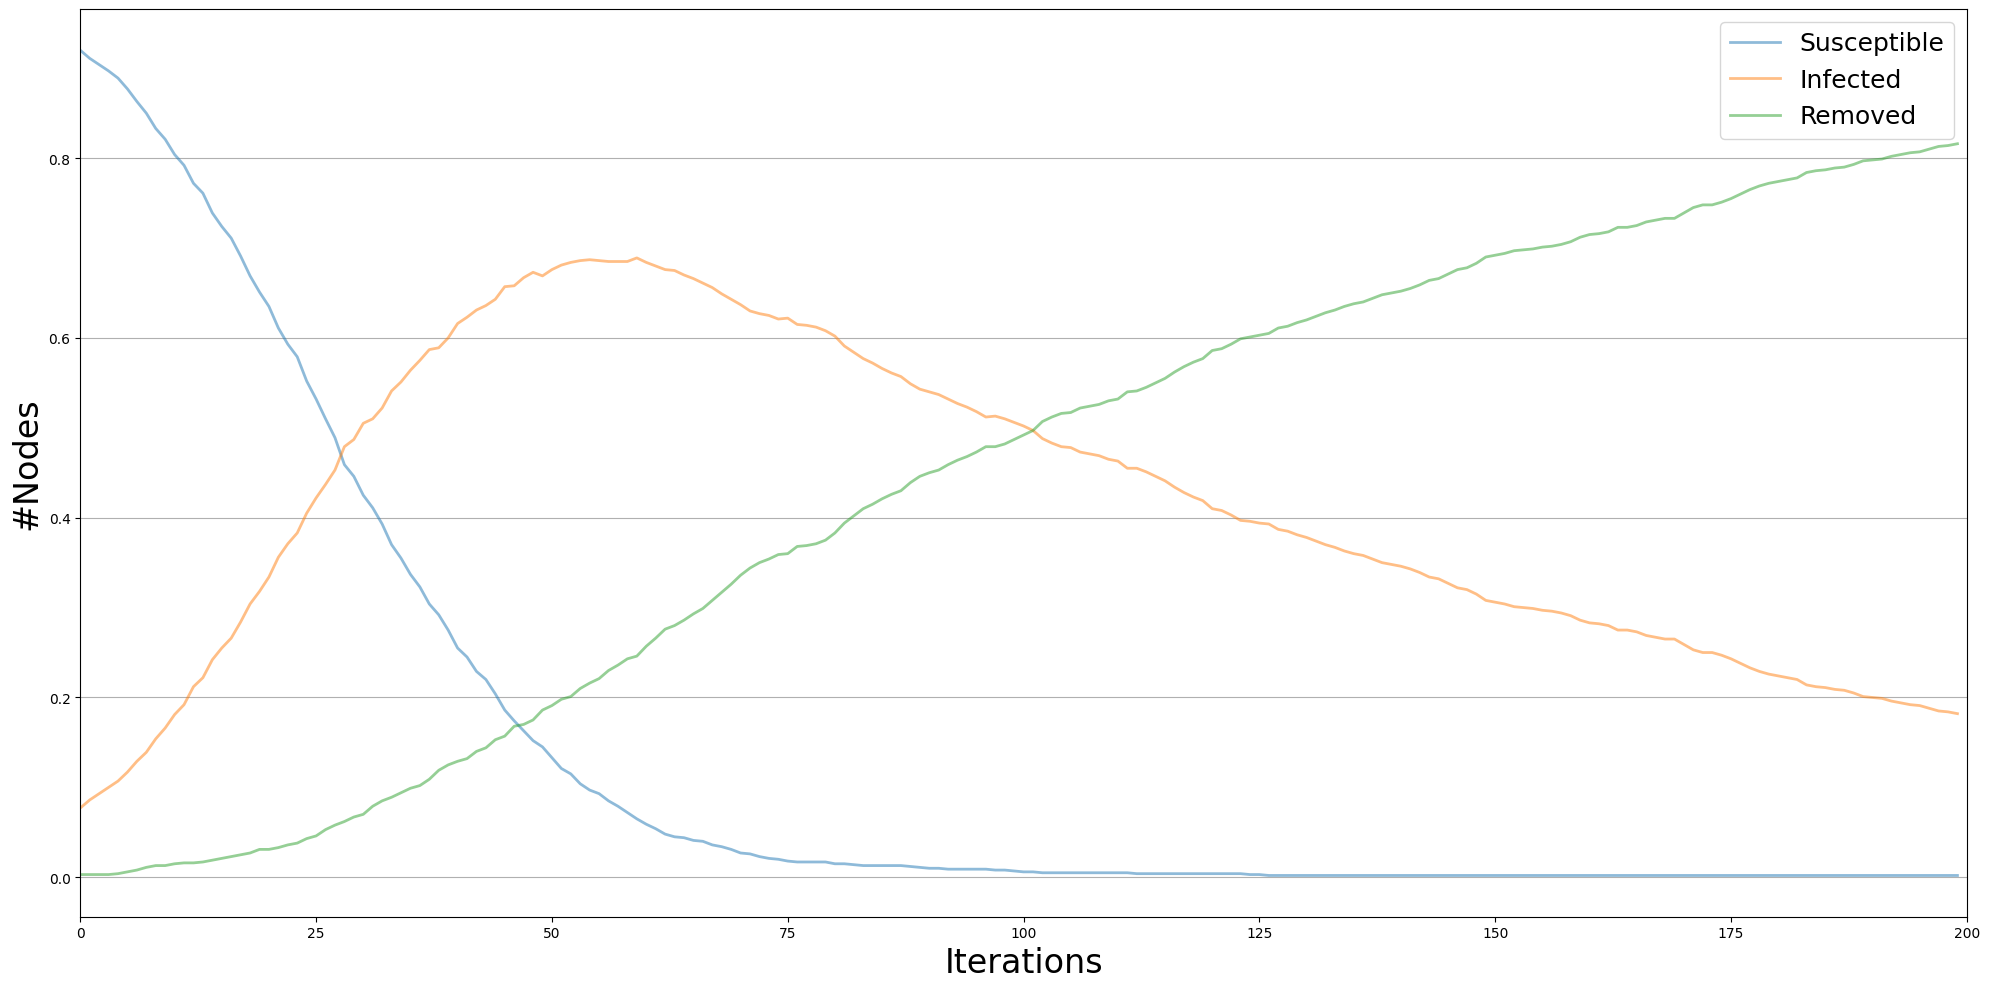

In [6]:
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

viz = DiffusionTrend(model, trends)
viz.plot()

Drugi wykres pokazuje zmiany w liczebności poszczególnych grup między kolejnymi iteracjami.

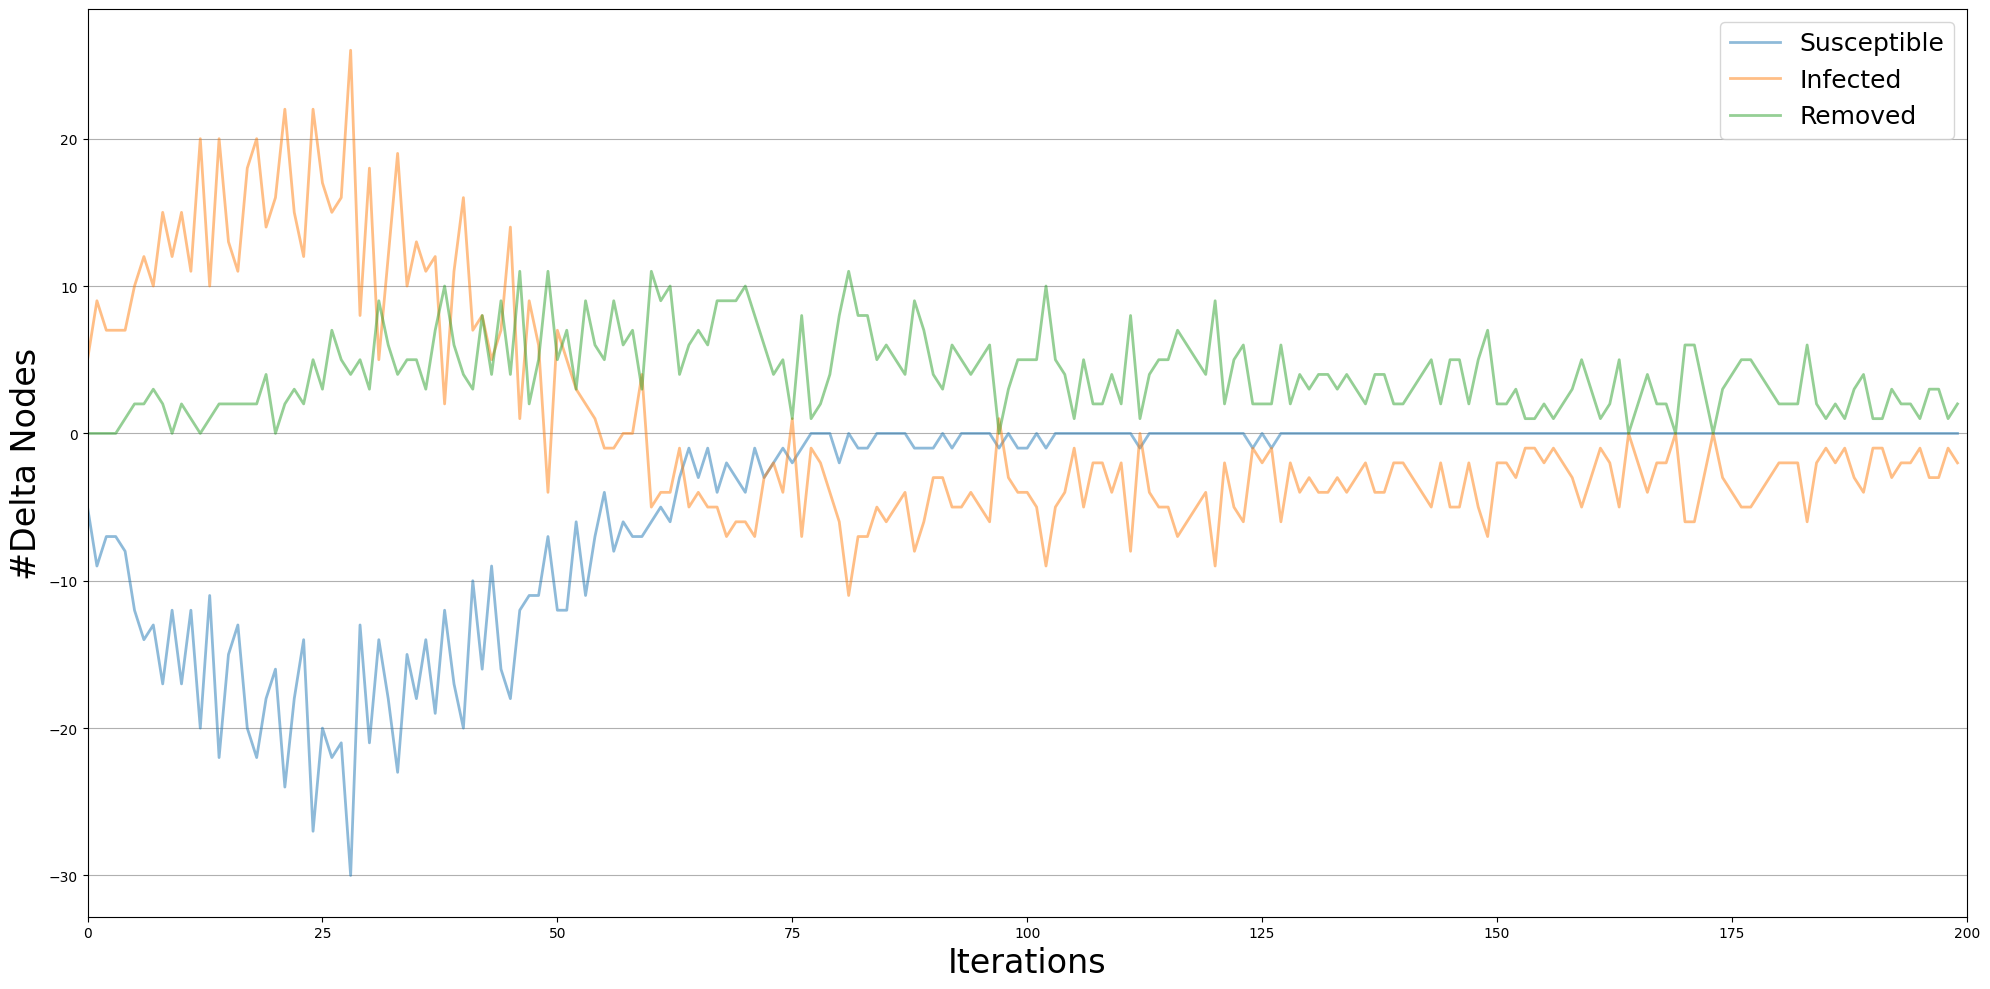

In [7]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

viz2 = DiffusionPrevalence(model, trends)
viz2.plot()

## NDQL: Network Diffusion Query Language

Ciekawą możliwością jest opcja definiowania eksperymentu w języku `NDQL`. Jest to prosty deklaratywny język umożliwiający definiowanie eksperymentów i symulacji z dyfuzją sieciową przy pomocy dwóch komponentów:
- statusów wierzchołków
- reguł przejść między statusami

Język `NDQL` w chwili obecnej wspiera jedynie statyczne modele dyfuzji. Poniżej znajduje się przykład definicji modelu dyfuzji.

```
CREATE_NETWORK g1
TYPE erdos_renyi_graph
PARAM n 300
PARAM p 0.1

MODEL SIR

STATUS Susceptible
STATUS Infected
STATUS Removed

# definicja kolekcji wierzchołków

COMPARTMENT c1
TYPE NodeStochastic
PARAM rate 0.1
TRIGGER Infected

COMPARTMENT c2
TYPE NodeStochastic
PARAM rate 0.1

# definicja reguł przejść

RULE
FROM Susceptible
TO Infected
USING c1

RULE
FROM Infected
TO Removed
USING c2

# konfiguracja modelu

INITIALIZE
SET Infected 0.1

EXECUTE SIR ON g1 FOR 5
```

Po przygotowaniu takiego pliku można wykorzystać dwie komendy:
- `NDQL_translate query_file python_file`
- `NDQL_execute query_file output_file`

In [ ]:
!NDQL_translate sir.ndql sir.py

In [ ]:
!cat sir.py

In [ ]:
!NDQL_execute sir.ndql out.txt

In [ ]:
!cat out.txt

## Budowanie własnego modelu: apokalipsa zombie

Biblioteka `ndlib` umożliwia łatwe zdefiniowanie własnego modelu. Podobnie jak w przypadku `NDQL`, kluczowe jest zdefiniowanie możliwych statusów oraz reguł przejścia między nimi. Modele mogą być budowane na trzy sposoby:
- `CompositeModel`: model dyfuzji z dyskretnymi stanami działający na statycznym grafie
- `DynamicCompositeModel`: model dyfuzji z dyskretnymi stanami działający na dynamicznym grafie
- `ContinuousModel`: model dyfuzji z ciągłymi stanami działający na statycznym lub dynamicznym grafie 

Jako przykład własnego modelu zaimplementujemy model reprezentujący wybuch epidemii zombie. Zgodnie z modelem:
- człowiek może umrzeć z przyczyn naturalnych lub jako wynik ataku zombie
- zmarły może powrócić do życia jako zombie
- możliwe jest też stanie się zombie w wyniku ugryzienia (atak zombie na człowieka może skończyć się albo śmiercią, albo zombifikacją)
- tylko ludzie mogą stać się zombie, aktualne zombie nie wpływają na inne zombie
- człowiek może zabić zombie

W pierwszym kroku zdefiniujemy trzy możliwe stany w jakich może znajdować się człowiek

In [8]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt

%matplotlib inline 

g = nx.erdos_renyi_graph(1000, 0.1)

model = gc.CompositeModel(g)

model.add_status("Susceptible")
model.add_status("Infected")
model.add_status("Removed")

Kolejnym krokiem jest zdefiniowanie warunków wyzwalających przejście między stanami.

In [9]:
c1 = cpm.NodeStochastic(0.02, triggering_status="Infected") # Susceptible - Zombie
c2 = cpm.NodeStochastic(0.01) # Susceptible - Removed
c3 = cpm.NodeStochastic(0.01) # Zombie - Removed
c4 = cpm.NodeStochastic(0.01) # Removed - Zombie

Konieczne jest też powiązanie warunków wyzwalających z konkretnymi stanami.

In [10]:
model.add_rule("Susceptible", "Infected", c1)
model.add_rule("Susceptible", "Removed", c2)
model.add_rule("Infected", "Removed", c3)
model.add_rule("Removed", "Infected", c4)

Ostatnim krokiem jest zapisanie konfiguracji, ustalenie stanu początkowego i uruchomienie eksperymentu.

In [11]:
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.001)

model.set_initial_status(config)
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

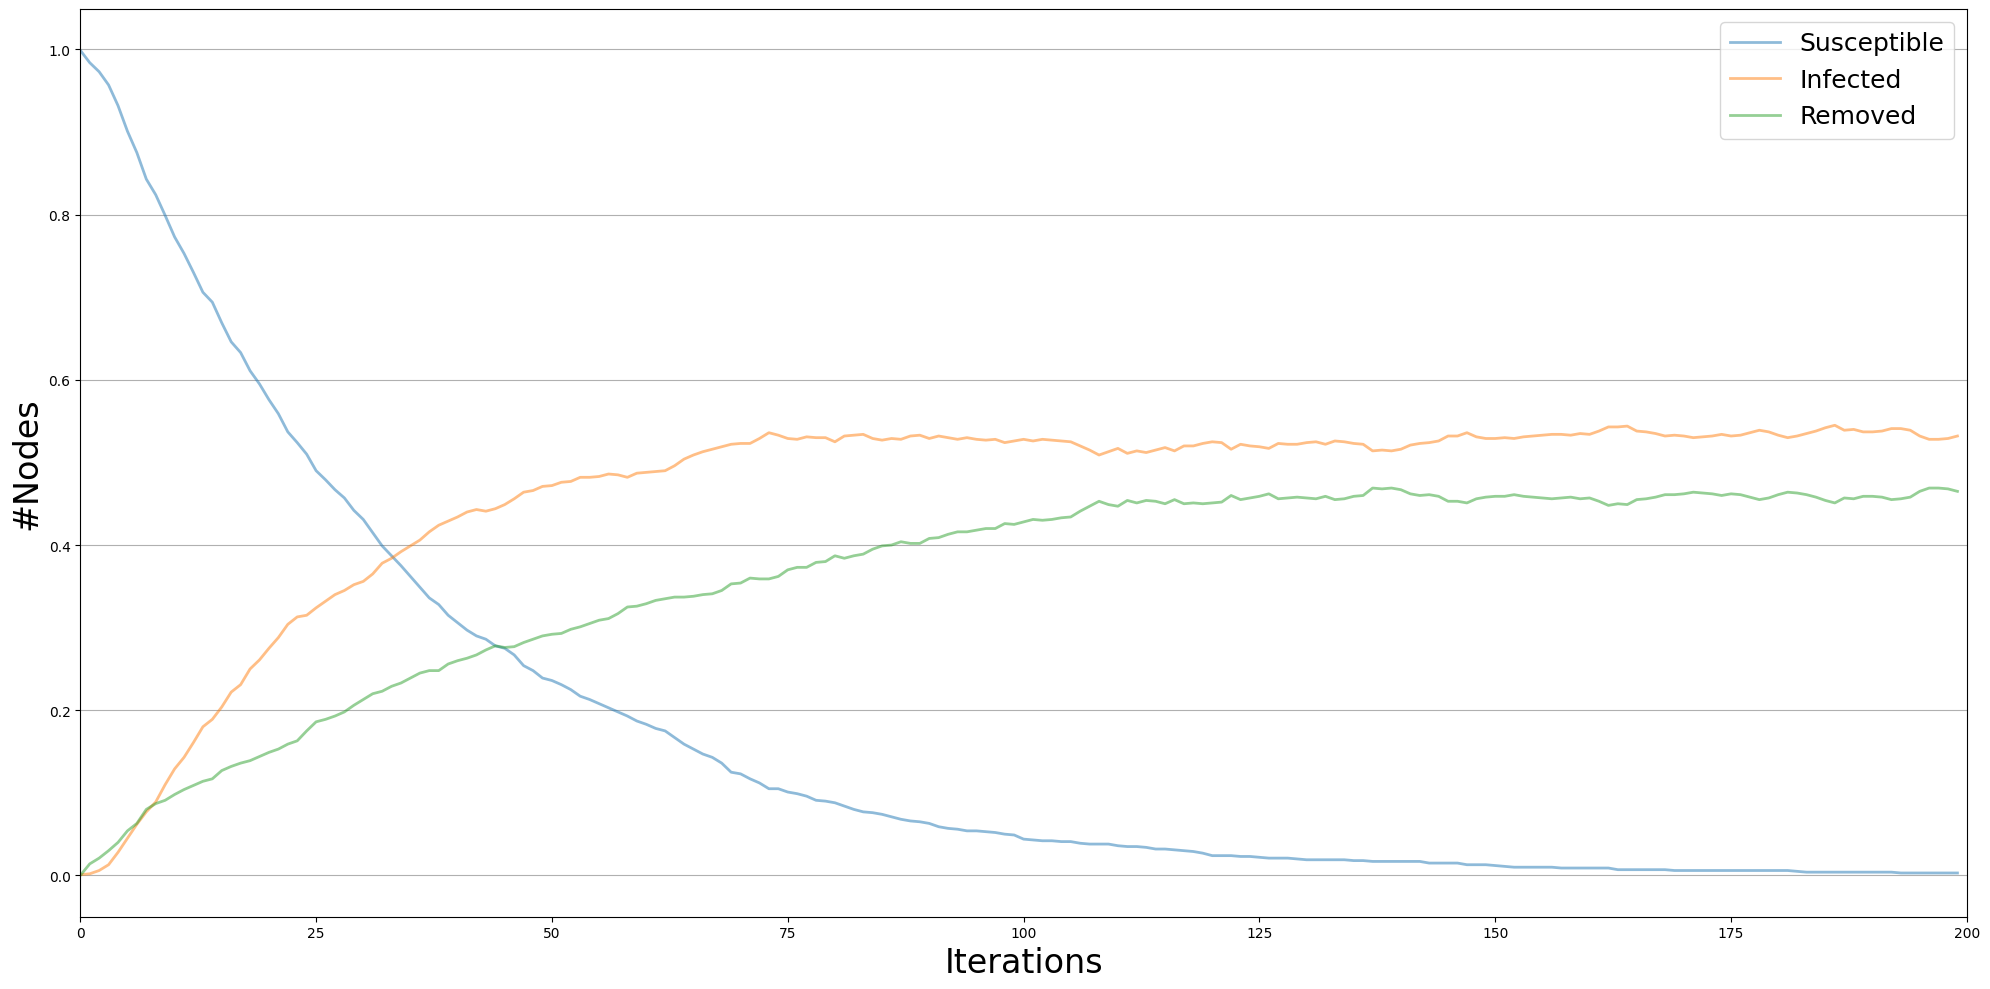

In [12]:
viz = DiffusionTrend(model, trends)
viz.plot()

Zmodyfikujmy teraz model w taki sposób, aby dodać czas między ugryzieniem a zombifikacją. Oznacza to, że po ugryzieniu osoby przechodzą do stanu *infected*, a dopiero po pewnym czasie ze stanu *infected* przechodzą do stanu *zombie*. Człowiek nadal może umrzeć z przyczyn naturalnych w stanie *infected* zanim zacznie aktywnie zarażać innych.

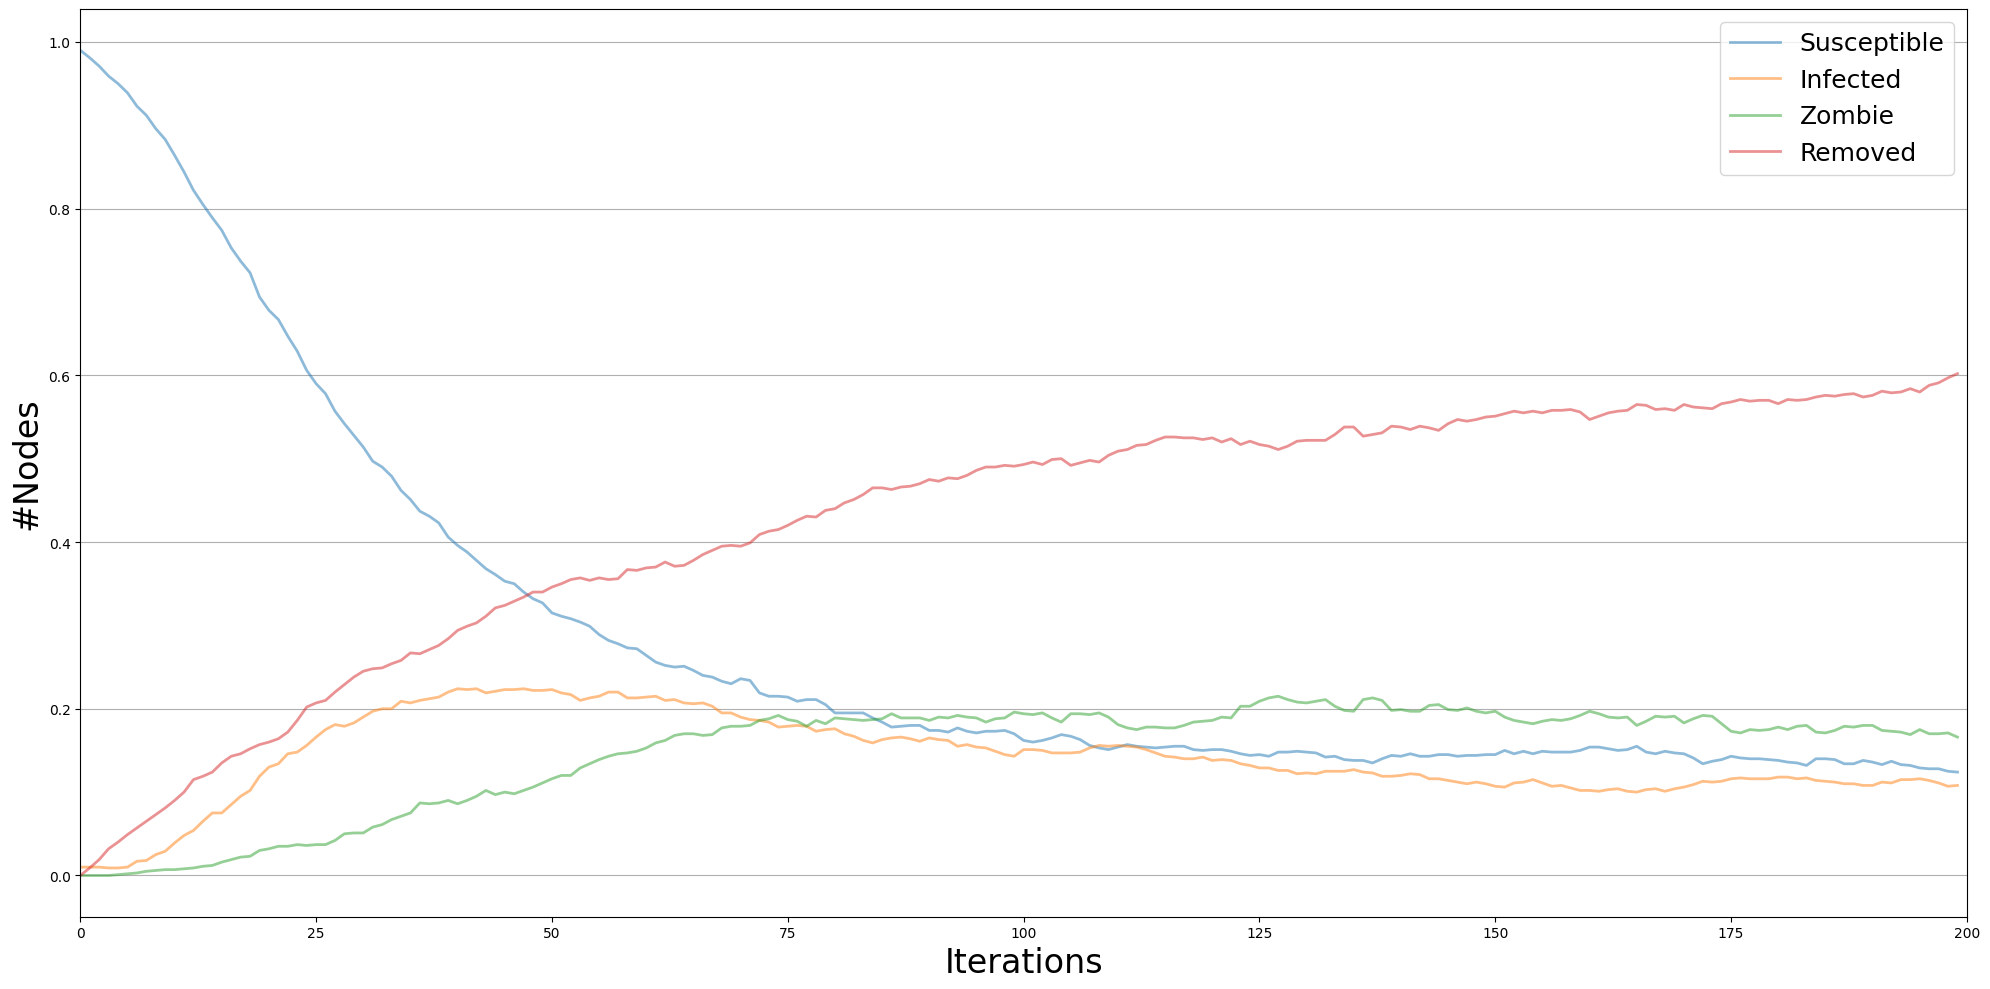

In [14]:
g = nx.erdos_renyi_graph(1000, 0.1)

model = gc.CompositeModel(g)

model.add_status("Susceptible")
model.add_status("Infected")
model.add_status("Zombie")
model.add_status("Removed")

c_alpha = cpm.NodeStochastic(0.02, triggering_status="Susceptible")
c_beta = cpm.NodeStochastic(0.02, triggering_status="Zombie")
c_gamma = cpm.NodeStochastic(0.01)
c_delta = cpm.NodeStochastic(0.01)
c_rho = cpm.NodeStochastic(0.02)
c_eta = cpm.NodeStochastic(0.02)

model.add_rule("Susceptible", "Infected", c_beta)
model.add_rule("Infected", "Zombie", c_rho)
model.add_rule("Zombie", "Removed", c_alpha)
model.add_rule("Removed", "Zombie", c_gamma)
model.add_rule("Susceptible", "Removed", c_delta)
model.add_rule("Infected", "Removed", c_delta)
model.add_rule("Zombie", "Susceptible", c_eta)

config = mc.Configuration()
config.add_model_parameter('fraction_Zombie', 0.0)
config.add_model_parameter('fraction_infected', 0.01)

model.set_initial_status(config)
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

viz = DiffusionTrend(model, trends)
viz.plot()

### zadanie samodzielne

Zmodyfikuj powyższy model w taki sposób, aby umożliwić wyleczenie zainfekowanej osoby. Zarówno zombie, jak i osoba zainfekowana która jeszcze nie przeszła transformacji, może otrzymać lek który spowoduje, że ze stanu *zombie* lub *infected* przejdzie do stanu *susceptible*. Dla uproszczenia przyjmij, że lek nie gwarantuje odporności, tzn. osoba która została wyleczona z zombiactwa może ponownie stać się zombie.

## Modele ciągłe

Biblioteka `ndlib` pozwala także na implementację modeli ciągłych, w których przejścia między stanami odbywają się całkowicie asynchronicznie. Jako przykład zbudujemy model reprezentujący wpływ społeczny w przypadku rozprzestrzeniania się szkodliwych nawyków (np. palenie lub użycie narkotyków). W modelu występują następujące stany:
- *C: craving*: osoba znajduje się w wewnętrznym stanie potrzeby
- *S: self control*: osoba panuje nad swoją wewnętrzną potrzebą
- *A: addiction*: osoba znajduje się w silnym stanie uzależnienia
- *E: external influence*: osoba widzi aktualny stan sąsiadów w sieci społecznościowej 
- *V: vulnerability*: osoba znajduje się w stanie podatności na potrzebę

W zależności od otoczenia i stanu wewnętrznego każdy wierzchołek podejmuje akcję (*acting out*) losowo zgodnie rozkładem Poissona, gdzie parametr $\lambda$ jest uzależniony od stanu osoby. Szczegółowy opis modelu można znaleźć w pracy [The Dynamics of Addiction: Craving versus Self-Control](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0158323&type=printable)

Pierwszym krokiem jest zdefiniowanie funkcji reprezentujących początkowy stan modelu.

Przejścia między stanami ilustruje poniższy rysunek

![states](states.jpg)

Podatność (*vulnerability*) jest sumą pożądania (*craving*), samokontroli (*self-control*) i czynników zewnętrznych (*external influence*). Zachowanie (*acting out*) jest proporcjonalne do podatności. Samokontrola ulega zmniejszeniu w efekcie zachowania, ale z drugiej strony jest nieustannie podnoszone do maksymalnego poziomu $S^+$. Początkowo czynniki zewnętrzne zmniejszają podatność, ale w trakcie symulacji może się okazać, że wpływ czynników zewnętrznych staje się negatywny (np. sąsiedzi w grafie popadają w nałóg). Zachowanie podnosi pożądanie, które z kolei obniża samokontrolę.

In [15]:
from ndlib.models.ContinuousModel import ContinuousModel
from ndlib.models.compartments.NodeStochastic import NodeStochastic

import ndlib.models.ModelConfig as mc
import numpy as np

constants = {
    'q': 0.8,
    'b': 0.5,
    'd': 0.2,
    'h': 0.2,
    'k': 0.25,
    'S+': 0.5,
}
constants['p'] = 2*constants['d']

def initial_v(node, graph, status, constants):
    return min(1, max(0, status['C']-status['S']-status['E']))

def initial_a(node, graph, status, constants):
    return constants['q'] * status['V'] + (np.random.poisson(status['lambda'])/7)

initial_status = {
    'C': 0,
    'S': constants['S+'],
    'E': 1,
    'V': initial_v,
    'lambda': 0.5,
    'A': initial_a
}

Następnym krokiem jest zdefiniowanie reguł aktualizacji stanów

In [16]:
def update_C(node, graph, status, attributes, constants):
    return status[node]['C'] + constants['b'] * status[node]['A'] * min(1, 1-status[node]['C']) - constants['d'] * status[node]['C']

def update_S(node, graph, status, attributes, constants):
    return status[node]['S'] + constants['p'] * max(0, constants['S+'] - status[node]['S']) - constants['h'] * status[node]['C'] - constants['k'] * status[node]['A']

def update_E(node, graph, status, attributes, constants):
    # return status[node]['E'] - 0.015 # Grasman calculation

    avg_neighbor_addiction = 0
    for n in graph.neighbors(node):
        avg_neighbor_addiction += status[n]['A']

    return max(-1.5, status[node]['E'] - avg_neighbor_addiction / 50) # Custom calculation

def update_V(node, graph, status, attributes, constants):
    return min(1, max(0, status[node]['C']-status[node]['S']-status[node]['E']))

def update_lambda(node, graph, status, attributes, constants):
    return status[node]['lambda'] + 0.01

def update_A(node, graph, status, attributes, constants):
    return constants['q'] * status[node]['V'] + min((np.random.poisson(status[node]['lambda'])/7), constants['q']*(1 - status[node]['V']))

Następnym krokiem jest zbudowanie grafu źródłowego oraz skonfigurowanie wizualizacji.

In [17]:
g = nx.random_geometric_graph(200, 0.125)

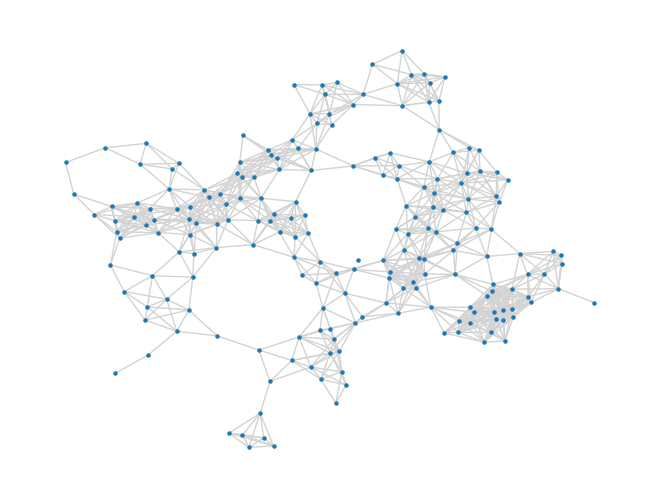

In [18]:
nx.draw(g, node_size=5, edge_color="lightgray", pos=nx.layout.kamada_kawai_layout(g))

In [19]:
visualization_config = {
    'plot_interval': 1,
    'plot_variable': 'A',
    'variable_limits': {
        'A': [0, 0.8],
        'lambda': [0.5, 1.5]
    },
    'show_plot': True,
    'plot_output': './c_vs_s.gif',
    'plot_title': 'Self control vs craving',
}

Ostatnim krokiem jest dodanie możliwych stanów, dodanie reguł przejścia między stanami, oraz uruchomienie symulacji

In [20]:
craving_control_model = ContinuousModel(g, constants=constants)
craving_control_model.add_status('C')
craving_control_model.add_status('S')
craving_control_model.add_status('E')
craving_control_model.add_status('V')
craving_control_model.add_status('lambda')
craving_control_model.add_status('A')

condition = NodeStochastic(1)

craving_control_model.add_rule('C', update_C, condition)
craving_control_model.add_rule('S', update_S, condition)
craving_control_model.add_rule('E', update_E, condition)
craving_control_model.add_rule('V', update_V, condition)
craving_control_model.add_rule('lambda', update_lambda, condition)
craving_control_model.add_rule('A', update_A, condition)

config = mc.Configuration()
craving_control_model.set_initial_status(initial_status, config)
craving_control_model.configure_visualization(visualization_config)

iterations = craving_control_model.iteration_bunch(100, node_status=True)
trends = craving_control_model.build_trends(iterations)

Configuring visualization...
Done configuring the visualization


In [25]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

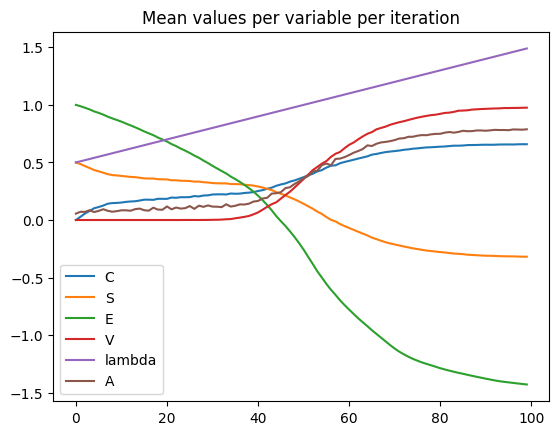

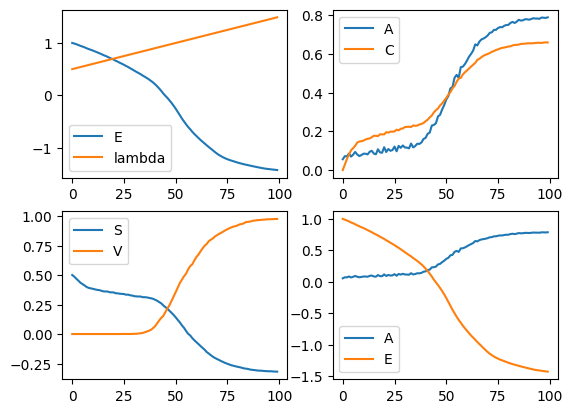

In [26]:
craving_control_model.plot(trends, len(iterations))

x = np.arange(0, len(iterations))

plt.figure()

plt.subplot(221)
plt.plot(x, trends['means']['E'], label='E')
plt.plot(x, trends['means']['lambda'], label='lambda')
plt.legend()

plt.subplot(222)
plt.plot(x, trends['means']['A'], label='A')
plt.plot(x, trends['means']['C'], label='C')
plt.legend()

plt.subplot(223)
plt.plot(x, trends['means']['S'], label='S')
plt.plot(x, trends['means']['V'], label='V')
plt.legend()

plt.subplot(224)
plt.plot(x, trends['means']['A'], label='A')
plt.plot(x, trends['means']['E'], label='E')
plt.legend()

plt.show()

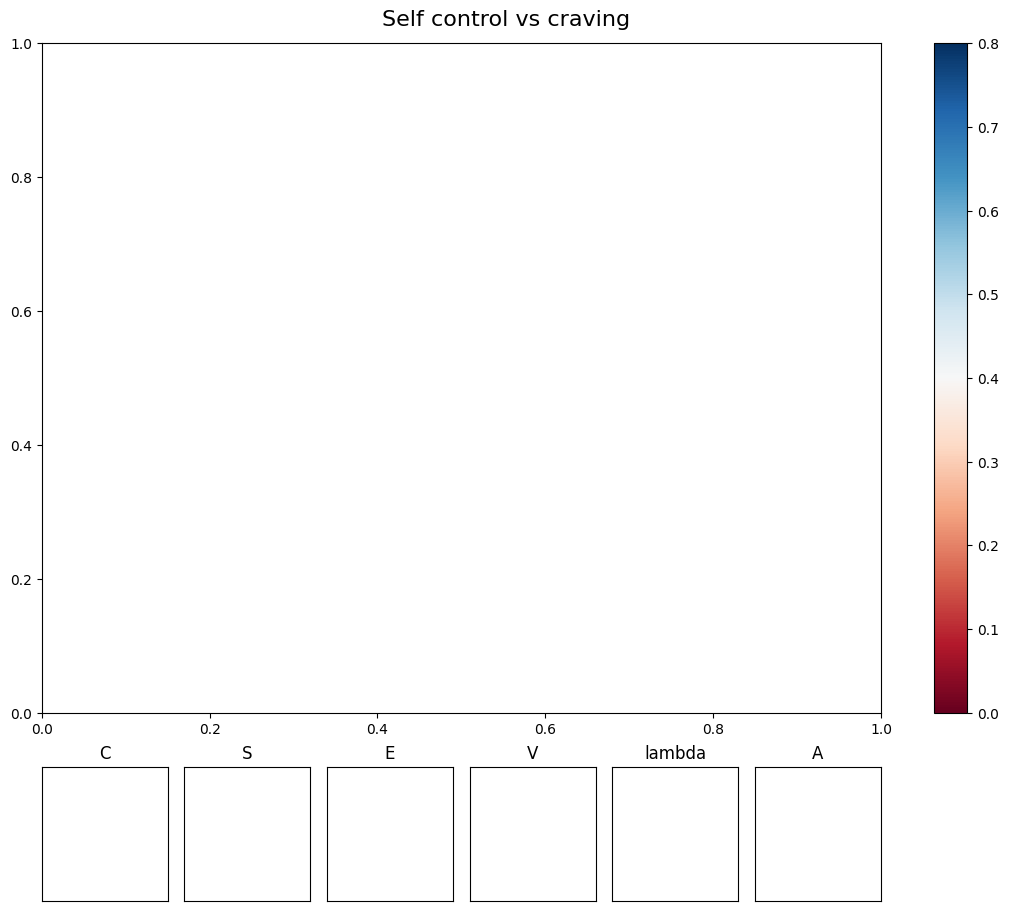

Saving plot at: ./c_vs_s.gif ...
Saved: ./c_vs_s.gif


In [37]:
vis3 = craving_control_model.visualize(iterations)

![SegmentLocal](c_vs_s.gif "segment")